# Minimal Effort Example with CEM on MNIST

Suppose you want to generate the pertinent positive explanation (_CEM_) of a handwritten digit from the _MNIST dataset_. First and foremost, you have to make sure of the following things:

- You have the dataset and an inference model accessible.
- As we will utilize the _Contrastive Explanation Method_, it is necessary that the prediction result is of a classification problem format, e.g. `[0.1, 5.23, 2.34, 12.01]` - where each entry indicates the score of likelihood of the class being present in the image.


<details open>
<summary>Our model prediction for the image in <b>step three</b> below:</summary>

```
[ 34.32501    -12.048843     1.2531171   -8.700068    -8.913591
  -5.9139457    0.26711565  -2.6489842   -0.33851495   2.3089695 ]
```

</details>

Since the provided inference model ouputs the right format, we don't need to include the _Inference Wrapper_. 

For the CEM we have two kind of explanations to chose from:
- **Pertinent Positive** (PP): A pertinent positive is a factor whose presence is minimally sufficient in justifying the final classification. 
- **Pertinent Negative** (PN): A pertinent negative is a factor whose absence is necessary in asserting the final classification.

For the first part, we will generate the **PP** with our ```ExplanationGenerator``` using CEM. 
Now we can start writing the code:

1. **Import the required libraries**:

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import maxi

sys.path.append("../mnist/src")
from official_mnist_tf.train_mnist_model import load_mnist, init_model

2023-05-31 18:02:44.781075: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-31 18:02:44.816585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 18:02:45.334872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2. **Load the mnist data, model and autoencoder**:

In [ ]:
x_train, y_train, x_test, y_test = load_mnist()
model = init_model()
model.load_weights("../mnist/models/tf/tf")

3. **Chose an image to be explained**:

In [44]:
inputs = x_train[5].reshape(1, 28, 28)

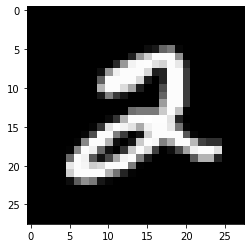

In [45]:
# this is how the image looks like
plt.imshow(inputs.squeeze(axis=0), cmap="gray", vmin=-0.0, vmax=1.0)

4. **Chose your desired component classes for the optimization (loss, optimizer and gradient). Then, specify the configuration of the components**:

In [36]:
loss_class = maxi.loss.TF_CEMLoss
optimizer_class = maxi.optimizer.AdaExpGradOptimizer
gradient_class = maxi.gradient.TF_Gradient

loss_kwargs = {"mode": "PP", "gamma": 0.0, "K": 2}
optimizer_kwargs = {"l1": 0.05, "l2": 0.005, "channels_first": False}
gradient_kwargs = {}

5. **Instantiate the `ExplanationGenerator` with our custom configuration**:

In [23]:
cem = maxi.ExplanationGenerator(
    loss=loss_class,
    optimizer=optimizer_class,
    gradient=gradient_class,
    loss_kwargs=loss_kwargs,
    optimizer_kwargs=optimizer_kwargs,
    gradient_kwargs=gradient_kwargs,
    num_iter=1000, # number of optimization iterations
    save_freq=250,  # at which iterations the result should be saved
    verbose=False,   # print optimization metrics
)

Note: The `save_freq` argument determines the frequency of which the intermediate results are saved into the output dictionary. With the settings above, the CEM explanation of every \_500_th iteration is saved. `save_freq` equals `np.inf` per default. Only the optimization result of the last iteration is saved in that case.

6. **Start the explanation procedure and retrieve the results**:

In [24]:
results, _ = cem.run(image=inputs, inference_call=model)

Note: The first return value is a OrderedDictionary that contains the savepoints keyed by the number of the respective iteration. The second return value would be a dictionary containing the images' meta data, which can be optionally parsed to the `maxi.ExplanationGenerator.run()` method. This is epescially useful when using the `maxi.AsyncExplanationWrapper` as it makes it simpler to distinguish between the different explanation results given the meta data.

7. **Display the results (savepoints)**:


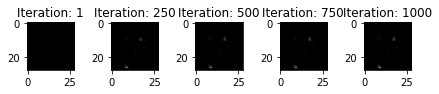

In [25]:
f, axarr = plt.subplots(1, len(results))
f.tight_layout()
for i, (iter_, result) in enumerate(results.items()):
    axarr[i].title.set_text("Iteration: " + iter_)
    axarr[i].imshow(
        result.squeeze(axis=0),
        cmap="gray",
        vmin=0.0,
        vmax=1.0,
    )

This sparse image, being a subspace of the original image, is sufficient to be classified as a **2**.

#### Now, we will generate the Pertinent-Negative

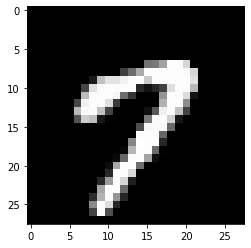

In [42]:
inputs = x_train[15].reshape(1, 28, 28)
# this is how the image looks like
plt.imshow(inputs.squeeze(axis=0), cmap="gray", vmin=-0.0, vmax=1.0)

In [26]:
loss_class = maxi.loss.TF_CEMLoss
optimizer_class = maxi.optimizer.AdaExpGradOptimizer
gradient_class = maxi.gradient.TF_Gradient

loss_kwargs = {"mode": "PN", "gamma": 0.0, "K": 10}
optimizer_kwargs = {"l1": 0.005, "l2": 0.0005, "channels_first": False}
gradient_kwargs = {}

In [27]:
cem = maxi.ExplanationGenerator(
    loss=loss_class,
    optimizer=optimizer_class,
    gradient=gradient_class,
    loss_kwargs=loss_kwargs,
    optimizer_kwargs=optimizer_kwargs,
    gradient_kwargs=gradient_kwargs,
    num_iter=1000, # number of optimization iterations
    save_freq=250,  # at which iterations the result should be saved
    verbose=False,   # print optimization metrics
)

In [28]:
results, _ = cem.run(image=inputs, inference_call=model)

Iter: 1 || Prediction: 7 || Prediction Score: [11.139979]
Iter: 250 || Prediction: 9 || Prediction Score: [10.135234]
Iter: 500 || Prediction: 9 || Prediction Score: [10.521185]
Iter: 750 || Prediction: 9 || Prediction Score: [10.653431]
Iter: 1000 || Prediction: 9 || Prediction Score: [10.746153]


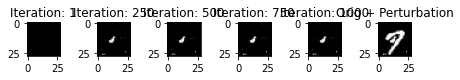

In [29]:
# visualize the savepoints
f, axarr = plt.subplots(1, len(results) + 1)
f.tight_layout()
for i, (iter_, result) in enumerate(results.items()):
    axarr[i].title.set_text("Iteration: " + iter_)
    axarr[i].imshow(
        result.squeeze(axis=0),
        cmap="gray",
        vmin=0.0,
        vmax=1.0,
    )
    
    pred = model(inputs + result)
    print(f"Iter: {iter_} || Prediction: {np.argmax(pred)} || Prediction Score: {np.max(pred, axis=1)}")

axarr[-1].title.set_text("Orig + Perturbation")
axarr[-1].imshow(
    (inputs + result).squeeze(axis=0),
    cmap="gray",
    vmin=0.0,
    vmax=1.0,
)

The first five images show the perturbations generated by our ExplanationGenerator. The last image shows the composition of the original image and PN. When we add the generated PN to the original image, it would be classified as a 9, opposed to a 7.